In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

In [33]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
n_classes = 4

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/sf-dataset/Original Image/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 326 files belonging to 4 classes.


In [35]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/sf-dataset/Original Image/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 140 files belonging to 4 classes.


In [36]:
class_names = train_ds.class_names

# Prefetch datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [37]:
# Define Inception module
def inception_module(x, f1, f3_r, f3, f5_r, f5, pool_proj):
    conv1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3)
    conv5 = layers.Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5)
    pool_proj_layer = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj_layer = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(pool_proj_layer)
    output = layers.concatenate([conv1, conv3, conv5, pool_proj_layer], axis=-1)
    return output

In [38]:
# Define GoogLeNet-like architecture
input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

In [39]:
# Inception modules
x = inception_module(x, 64, 96, 128, 16, 32, 32)
x = inception_module(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 192, 96, 208, 16, 48, 64)
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
x = inception_module(x, 112, 144, 288, 32, 64, 64)
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 256, 160, 320, 48, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128, 128)

In [40]:
# Final layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(n_classes, activation='softmax')(x)

In [41]:
# Build and compile the model with a reduced learning rate
model = models.Model(input_layer, output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [42]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 56, 56,    │    110,784 │ conv2d_58[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 28, 28,    │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 28, 28,    │     18,528 │ max_pooling2d_14… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 28, 28,    │      3,088 │ max_pooling2d_14… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 28, 28,    │          0 │ max_pooling2d_14… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 28, 28,    │     12,352 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 28, 28,    │    110,720 │ conv2d_61[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 28, 28,    │     12,832 │ conv2d_63[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 28, 28,    │      6,176 │ max_pooling2d_15… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 28, 28,    │          0 │ conv2d_60[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_62[0][0],  │
│                     │                   │            │ conv2d_64[0][0],  │
│                     │                   │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate_9[0]… │
│                     │ 32)               │            │                 

 Total params: 6,042,180 (23.05 MB)

 Trainable params: 6,042,180 (23.05 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    verbose=1
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 8.8087e-06 - val_accuracy: 0.7286 - val_loss: 2.0331
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 7.8303e-06 - val_accuracy: 0.7286 - val_loss: 2.0306
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 1.1247e-05 - val_accuracy: 0.7214 - val_loss: 2.0255
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 7.5209e-06 - val_accuracy: 0.7286 - val_loss: 2.0226
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 5.8787e-06 - val_accuracy: 0.7214 - val_loss: 2.0286
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 6.5585e-06 - val_accuracy: 0.7214 - val_loss: 2.0520
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 1.5406e-05 - val_accuracy: 0.7286 - val_loss: 2.0771
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - los

In [62]:
# Evaluate the model on test set
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7183 - loss: 2.2317
Test Accuracy: 72.14%


In [63]:
# Plot training/test accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Test Accuracy')

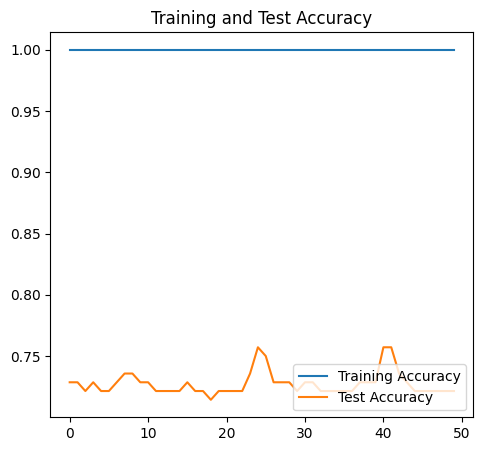

In [64]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')


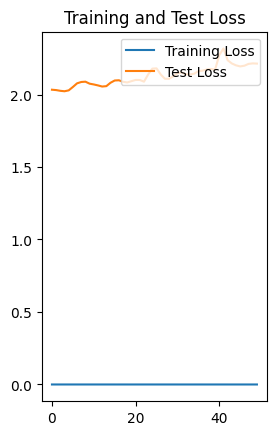

In [65]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


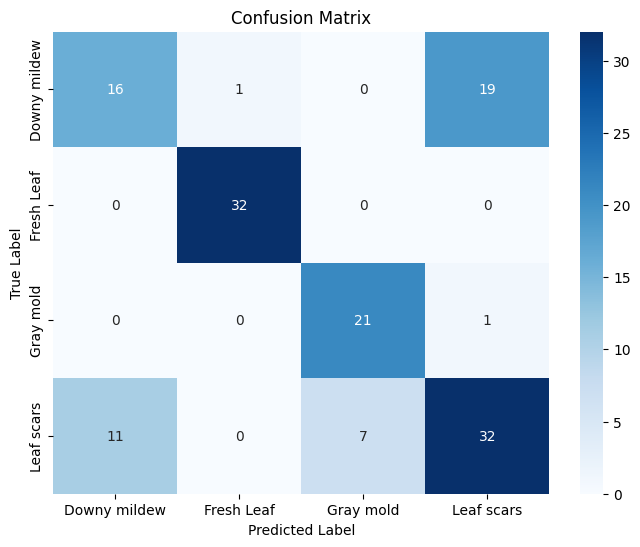

              precision    recall  f1-score   support

Downy mildew       0.59      0.44      0.51        36
  Fresh Leaf       0.97      1.00      0.98        32
   Gray mold       0.75      0.95      0.84        22
  Leaf scars       0.62      0.64      0.63        50

    accuracy                           0.72       140
   macro avg       0.73      0.76      0.74       140
weighted avg       0.71      0.72      0.71       140



In [66]:
# Confusion matrix and classification report
y_true = []
y_pred = []
for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=-1))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

In [67]:
model.save("sunflowermodel.h5")
